In [1]:
import sys
import numpy as np
import scipy.stats
from matplotlib import pyplot as plt
import pandas as pd
import json
import numpy.fft
from decimal import Decimal
import math
import numpy as np
import matplotlib.pyplot as plt
from pyts.approximation import PAA
%matplotlib inline

In [3]:
data = pd.read_csv("/Users/mislam/Desktop/Data/debs2012.txt",sep='\t',error_bad_lines=False)
data.head()
data.shape

b'Skipping line 36000: expected 56 fields, saw 111\n'
b'Skipping line 71999: expected 56 fields, saw 111\n'
b'Skipping line 719998: expected 56 fields, saw 111\n'
b'Skipping line 7319680: expected 56 fields, saw 111\n'
b'Skipping line 18453793: expected 56 fields, saw 111\n'
b'Skipping line 22725937: expected 56 fields, saw 112\n'
b'Skipping line 28247589: expected 56 fields, saw 111\n'
b'Skipping line 28473136: expected 56 fields, saw 111\n'
b'Skipping line 28880898: expected 56 fields, saw 111\n'
b'Skipping line 29077791: expected 56 fields, saw 111\n'
b'Skipping line 29287746: expected 56 fields, saw 111\n'
b'Skipping line 31847342: expected 56 fields, saw 111\n'


(32390505, 56)

In [4]:
data.head()

,2012-02-22T16:46:28.9670320+00:00,2556001,13056,14406,8119,0071,0193,0150,0000,0000.1,...,0.30,0.31,0.32,0.33,0.34,0.35,0.36,0.37,0.38,0.39
0,2012-02-22T16:46:28.9770284+00:00,2556002,13054,14405,8119,69,192,151,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2012-02-22T16:46:28.9870216+00:00,2556003,13049,14404,8119,70,194,152,0,0,...,0,0,0,0,0,0,0,0,0,0
2,2012-02-22T16:46:28.9970430+00:00,2556004,13051,14401,8118,71,193,152,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2012-02-22T16:46:29.0070267+00:00,2556005,13049,14397,8116,69,191,156,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2012-02-22T16:46:29.0170276+00:00,2556006,13046,14392,8113,64,191,155,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
#ASAP
import sys
import numpy as np
import scipy.stats
from matplotlib import pyplot as plt
import pandas as pd
import json
import numpy.fft
from decimal import Decimal
import math
import numpy as np
import matplotlib.pyplot as plt
from pyts.approximation import PAA
%matplotlib inline
# ASAP Simple (Brute Force)
def moving_average(data, _range):
    ret = np.cumsum(data, dtype=float)
    _range = int(_range)
    print(_range, "range")
    ret[_range:] = ret[_range:] - ret[:-_range]
    return ret[_range - 1:] / _range

def SMA(data, _range, slide):
    slide = int(slide)
    ret = moving_average(data, _range)[::slide]
    return list(ret)

def kurtosis(values):
    return scipy.stats.kurtosis(values)

def roughness(vals):
    return np.std(np.diff(vals))

def smooth_simple(data, max_window=5, resolution=None):
    data = np.array(data)
    # Preaggregate according to resolution
    window_size = 1
    slide_size = 1
    if resolution:
        slide_size = int(len(data) // resolution)
        if slide_size > 1:
            data = SMA(data, slide_size, slide_size)
    orig_kurt   = kurtosis(data)
    min_obj     = roughness(data)
    for w in range(2, len(data) // max_window + 1):
        smoothed = SMA(data, w, 1)
        if kurtosis(smoothed) >= orig_kurt:
            r = roughness(smoothed)
            if r < min_obj:
                min_obj = r
                window_size = w
    return window_size, slide_size
# ASAP
class Metrics(object):
    def __init__(self, values):
        self.set_values( values )

    def set_values(self, values):
        self.values = values
        self.r = self.k = None

    @property
    def kurtosis(self):
        if self.k is None:
            self.k = scipy.stats.kurtosis(self.values)
        return self.k

    @property
    def roughness(self):
        if self.r is None:
            self.r = np.std(np.diff(self.values))
        return self.r

class ACF(Metrics):
    CORR_THRESH = 0.2
    def __init__(self, values, max_lag=None):
        super(ACF, self).__init__(values)
        if max_lag is None:
            max_lag = len(values) / 5
        self.max_lag = int(max_lag)
        self.max_acf = 0.0

        # Calculate autocorrelation via FFT
        # Demean
        demeaned = values - np.mean(values)
        # Pad data to power of 2 
        l = int(2.0 ** (int(math.log(len(demeaned),2.0)) + 1))
        padded = np.append(demeaned, ([0.0] * (l - len(demeaned))))    
        # FFT and inverse FFT
        F_f = numpy.fft.fft( padded )
        R_t = numpy.fft.ifft( F_f * np.conjugate(F_f) )
        self.correlations = R_t[:int(max_lag)].real / R_t[0].real
        
        # Find autocorrelation peaks 
        self.peaks = []
        if len(self.correlations) >1 :
            positive = self.correlations[1] > self.correlations[0]
            max = 1
            for i in range(2, len(self.correlations)):
                if not positive and self.correlations[i] > self.correlations[i-1]:
                    max = i
                    positive = not positive
                elif positive and self.correlations[i] > self.correlations[max]:
                    max = i
                elif positive and self.correlations[i] < self.correlations[i-1]:
                    if max > 1 and self.correlations[max] > self.CORR_THRESH:
                        self.peaks.append(max)
                        if self.correlations[max] > self.max_acf:
                            self.max_acf = self.correlations[max]
                    positive = not positive
        # If there is no autocorrelation peak within the MAX_WINDOW boundary,
        # try windows from the largest to the smallest 
        if len(self.peaks) <= 1:
            self.peaks = range(2, len(self.correlations))
                    
def moving_average(data, _range):
    ret = np.cumsum(data)
    _range = int(_range)
    ret[_range:] = ret[_range:] - ret[:-_range]
    return ret[_range - 1:] / _range

def SMA(data, _range, slide):
    slide = int(slide)
    _range = int(_range)
    ret = moving_average(data, _range)[::slide]
    return list(ret)
                    
def binary_search(head,tail,data,min_obj,orig_kurt,window_size):
    while head <= tail:
        w = int(round((head + tail) / 2.0))
        smoothed = SMA(data,w,1)
        metrics  = Metrics(smoothed)
        if metrics.kurtosis >= orig_kurt:
            if metrics.roughness < min_obj:
                window_size = w
                min_obj = metrics.roughness
            head = w + 1
        else:
            tail = w - 1
    return window_size

def smooth_ASAP(data, max_window=5, resolution=None):
    data = np.array(data)
    # Preaggregate according to resolution
    slide_size = 1
    window_size = 1
    if resolution and len(data) >= 2 * resolution:
        slide_size = len(data) / resolution
        data = SMA(data, slide_size, slide_size)
    acf         = ACF(data, max_lag=len(data) / max_window)
    peaks       = acf.peaks
    orig_kurt   = acf.kurtosis
    min_obj     = acf.roughness
    lb          = 1
    largest_feasible = -1
    tail = len(data) / max_window
    for i in range(len(peaks) - 1, -1, -1):
        w = peaks[i]

        if w < lb or w == 1:
            break
        elif math.sqrt(1 - acf.correlations[w]) * window_size > math.sqrt(1 - acf.correlations[window_size]) * w:
            continue

        smoothed = SMA(data, w, 1)
        metrics = Metrics(smoothed)
        if metrics.roughness < min_obj and metrics.kurtosis >= orig_kurt:
            min_obj = metrics.roughness
            window_size = w
            lb = round( max(w*math.sqrt( (acf.max_acf -1) / (acf.correlations[w]-1) ), lb) )
    if largest_feasible > 0:
        if largest_feasible < len(peaks) - 2:
            tail = peaks[largest_feasible + 1]
        lb = max(lb, peaks[largest_feasible] + 1)

    window_size = binary_search(lb, tail, data, min_obj, orig_kurt, window_size)
    return window_size, slide_size
col = "mf3"
def window_sample(data,theta = 5):
    if(len(data) <=2):
        return data
    ret = []
    first = data.iloc[0]
    second = data.iloc[1]
    x1 = first["x"]
    x2 = second["x"]
    y1 = first[col]
    y2 = second[col]
    running_angle = np.rad2deg(np.arctan2(1.0*(y2-y1), 1.0*(x2-x1)))
    current_angle = running_angle
    others = data.iloc[2:len(data)]
    ret.append(first)
    prev = second
    for index, current in others.iterrows():
        x1 = prev["x"]
        x2 = current["x"]
        y1 = prev[col]
        y2 = current[col]
        current_angle = np.rad2deg(np.arctan2(1.0*abs(y2-y1), 1.0*abs(x2-x1)))
        #print("{0} {1} {2} {3} {4}".format(y1,y2,x1,x2,current_angle))
        if abs(current_angle - running_angle) > theta:
            running_angle = current_angle
            ret.append(prev)
            ret.append(current)
        prev = current
    ret.append(prev)
    return ret

In [6]:
data["t"] = data["2012-02-22T16:46:28.9670320+00:00"]
data["mf1"] =data["13056"]
data["mf2"] =data["14406"]
data["mf3"] = data["8119"]
data.drop("2012-02-22T16:46:28.9670320+00:00",axis = 1, inplace = True)
data.drop("13056",axis = 1, inplace = True)
data.drop("14406",axis = 1, inplace = True)
data.drop("8119",axis = 1, inplace = True)
data.head()

,2556001,0071,0193,0150,0000,0000.1,0000.2,0000.3,0,0.1,...,0.34,0.35,0.36,0.37,0.38,0.39,t,mf1,mf2,mf3
0,2556002,69,192,151,0,0,0,0,0,0,...,0,0,0,0,0,0,2012-02-22T16:46:28.9770284+00:00,13054,14405,8119
1,2556003,70,194,152,0,0,0,0,0,0,...,0,0,0,0,0,0,2012-02-22T16:46:28.9870216+00:00,13049,14404,8119
2,2556004,71,193,152,0,0,0,0,0,0,...,0,0,0,0,0,0,2012-02-22T16:46:28.9970430+00:00,13051,14401,8118
3,2556005,69,191,156,0,0,0,0,0,0,...,0,0,0,0,0,0,2012-02-22T16:46:29.0070267+00:00,13049,14397,8116
4,2556006,64,191,155,0,0,0,0,0,0,...,0,0,0,0,0,0,2012-02-22T16:46:29.0170276+00:00,13046,14392,8113


In [7]:
a  = "2012-03-20T06:53:51.4255462+00:00"
b  = "2012-03-20T06:53:51.4353528+00:00"
from datetime import datetime
import time
def parse_time(s):
    dst = s[0:19]
    dtime = datetime.strptime(dst,"%Y-%m-%dT%H:%M:%S")
    tm = time.mktime(dtime.timetuple())
    date,tme = s.split("T")
    y,mn,d = date.split("-")
    h,m,s,n = tme.split(":")
    s = s.split("+")[0]
    s = int(s.split(".")[1])
    s = s/10000000
    tm = tm + s
    #print(tm)
    return tm
parse_time(a)
parse_time(b)
trunc = data[["t","mf1","mf2","mf3"]]

In [8]:
trunc["x"] = trunc["t"].apply(lambda x: parse_time(x))
trunc.head()

/Users/mislam/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,t,mf1,mf2,mf3,x
0,2012-02-22T16:46:28.9770284+00:00,13054,14405,8119,1.329951e+09
1,2012-02-22T16:46:28.9870216+00:00,13049,14404,8119,1.329951e+09
2,2012-02-22T16:46:28.9970430+00:00,13051,14401,8118,1.329951e+09
3,2012-02-22T16:46:29.0070267+00:00,13049,14397,8116,1.329951e+09
4,2012-02-22T16:46:29.0170276+00:00,13046,14392,8113,1.329951e+09


In [9]:
import matplotlib.pyplot as plt
da = trunc.iloc[0:5000]

In [10]:
da.head()

,t,mf1,mf2,mf3,x
0,2012-02-22T16:46:28.9770284+00:00,13054,14405,8119,1.329951e+09
1,2012-02-22T16:46:28.9870216+00:00,13049,14404,8119,1.329951e+09
2,2012-02-22T16:46:28.9970430+00:00,13051,14401,8118,1.329951e+09
3,2012-02-22T16:46:29.0070267+00:00,13049,14397,8116,1.329951e+09
4,2012-02-22T16:46:29.0170276+00:00,13046,14392,8113,1.329951e+09


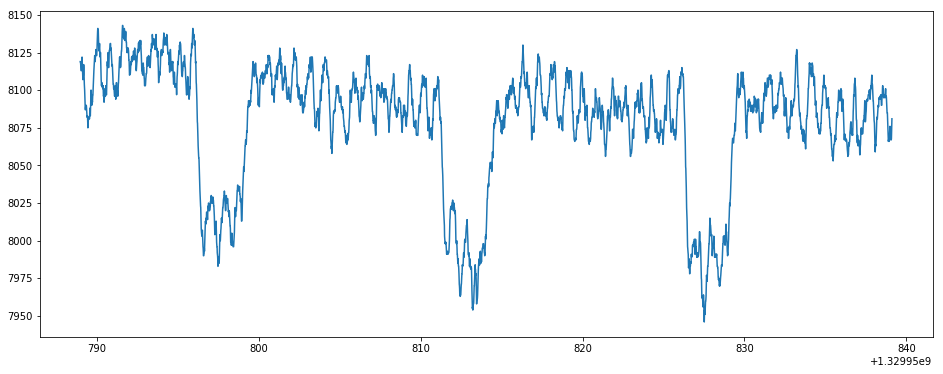

--- 0.15014982223510742 seconds ---


In [27]:
start = time.time()
X = np.array(da['x'])
Y = np.array(da['mf3'])
plt.figure(figsize=(16,6))
plt.plot(X,Y)
plt.savefig("d12/original.png")
plt.show()
end = time.time()

print("--- %s seconds ---" % (end - start))




2403


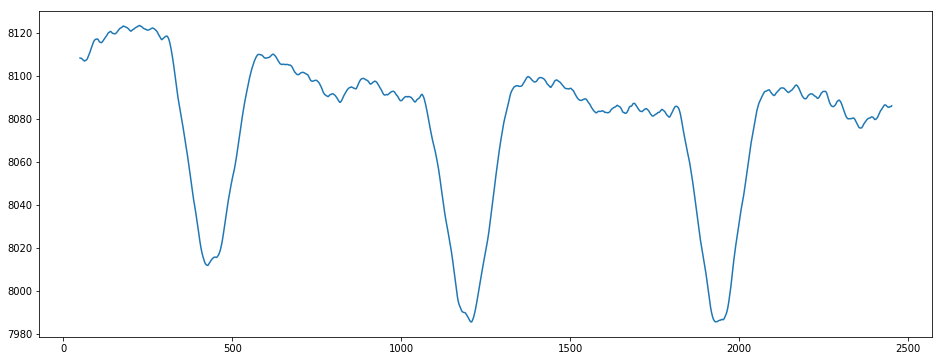

--- 0.1404869556427002 seconds ---


In [34]:
## ASAP ##
start = time.time()
mf3 = da["mf3"].tolist()
win_size, s_size = smooth_ASAP(mf3, resolution=2000)
#window_size, slide_size = smooth_simple(raw_data, resolution=1000)
dt = SMA(mf3, s_size, s_size)
smoothed = SMA(dt, win_size, 1)
smoothed_range = range(int(win_size/2), int(win_size/2) + len(smoothed))

plt.figure(figsize=(16,6))
plt.plot(smoothed_range,smoothed)
print(len(smoothed))

#plt.axis('off')
#plt.title("ASAP")
#plt.savefig('window_taxi.pdf')
#plt.axis('off')
plt.savefig("d12/asap.png")
plt.show()
end = time.time()
print("--- %s seconds ---" % (end - start))



--- 0.3195810317993164 seconds ---


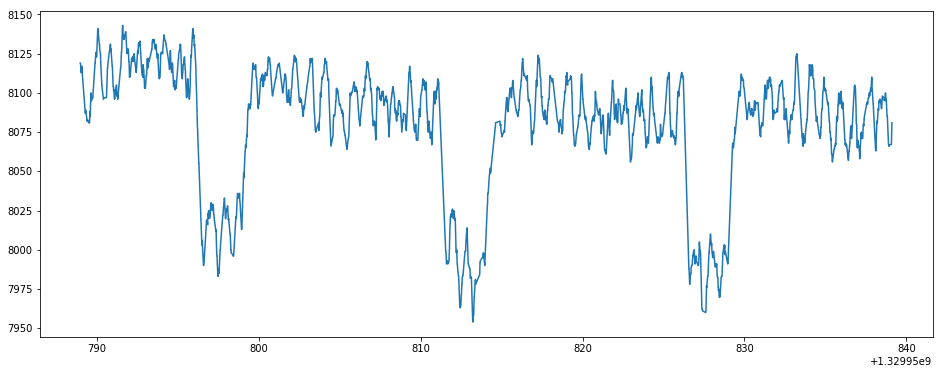

(2403, 5)


<Figure size 432x288 with 0 Axes>

In [33]:
# Winsample (PASS)
start = time.time()
wsample = window_sample(da,.46)
end = time.time()
print("--- %s seconds ---" % (end - start))


ws = {}
w = []
for a in wsample:
    if a["x"] not in ws:
        w.append(a)
        ws[a['x']] = True
len(w)

wframe = pd.DataFrame(w)
x = np.array(wframe['x'])
y = np.array(wframe['mf3'])
plt.figure(figsize=(16,6))

plt.plot(x,y)
plt.show()
plt.savefig("d12/wsample.png")
print(wframe.shape)



2500


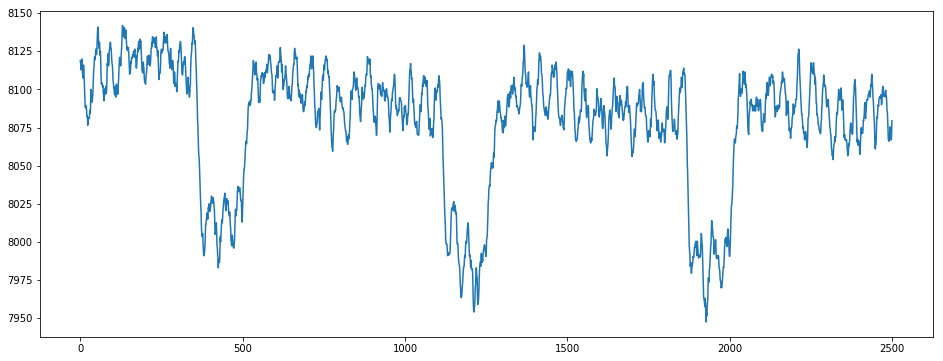

--- 0.1564340591430664 seconds ---


In [31]:
#PAA
start = time.time()
window_size = 2
paa = PAA(window_size=window_size)
X_paa = paa.transform([da["mf3"]])
print(len(X_paa[0]))
plt.figure(figsize=(16,6))
#plt.title("PAA(Window Size=4)")
plt.plot(X_paa[0])
plt.savefig("d12/paa.png")
plt.show()
end = time.time()
print("--- %s seconds ---" % (end - start))



2439


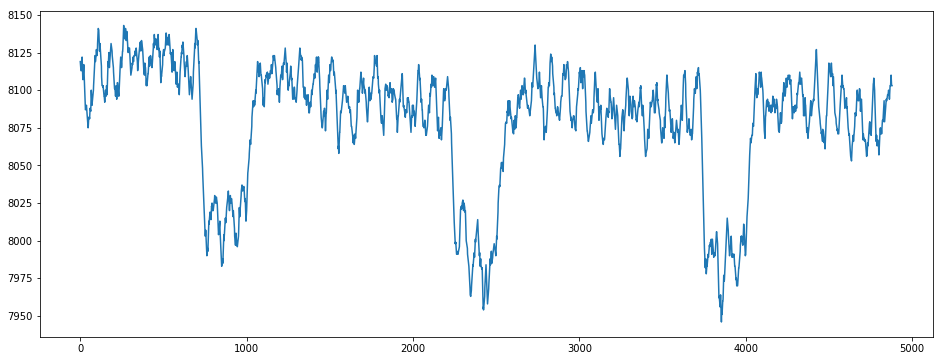

--- 1.9311997890472412 seconds ---


In [30]:
# M4
start = time.time()
w = 610
def m4(data, w):
    wsize = data.shape[0]//w
    ret = []
    seen = {}
    for g in range(0,w):
        maxv = None
        minv = None
        first = None
        last = None
        indices = [0,0,0,0]
        for i in range(g*wsize, g*wsize + wsize):
            if minv is None:
                minv = data.iloc[i]
                indices[0] = i
            elif data.iloc[i]["mf3"] < minv["mf3"]:
                minv = data.iloc[i]
                indices[0] = i
            if maxv is None:
                maxv = data.iloc[i]
                indices[1] = i
            elif data.iloc[i].mf3 > maxv.mf3:
                maxv = data.iloc[i]
                indices[1] = i
            if i == g*wsize:
                first = data.iloc[i]
                indices[2] = i
            if i == g*wsize + wsize - 1:
                last = data.iloc[i]
                indices[3] = i
        indices.sort()
        for j in range(0, len(indices)):
            if indices[j] in seen:
                continue
            seen[j] = True
            ret.append(data.iloc[indices[j]])
    df = pd.DataFrame(ret)
    #df = df.sort_values("timestamp")
    return df
ret = m4(da,w)

plt.figure(figsize=(16,6))
plt.plot(ret["mf3"])
print(len(ret["mf3"]))
fig = plt.gcf()
#plt.title("M4")
#plt.savefig('M4_taxi.pdf')
plt.savefig("d12/m4.png")
plt.show()
end = time.time()
print("--- %s seconds ---" % (end - start))



2440


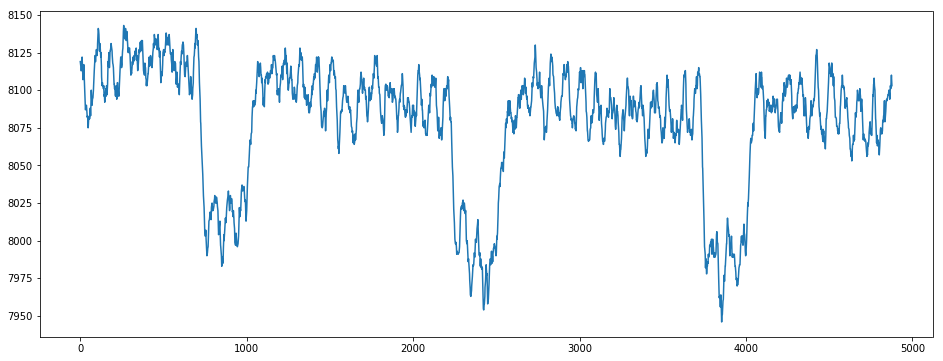

--- 1.727457046508789 seconds ---


In [29]:
# MinMax
start = time.time()
def minmax(data, w):
    wsize = data.shape[0]//w
    ret = []
    seen = {}
    for g in range(0,w):
        maxv = None
        minv = None
        indices = [0,0]
        for i in range(g*wsize, g*wsize + wsize):
            if minv is None:
                minv = data.iloc[i]
                indices[0] = i
            elif data.iloc[i]["mf3"] < minv["mf3"]:
                minv = data.iloc[i]
                indices[0] = i
            if maxv is None:
                maxv = data.iloc[i]
                indices[1] = i
            elif data.iloc[i].mf3 > maxv.mf3:
                maxv = data.iloc[i]
                indices[1] = i
        indices.sort()
        for j in range(0, len(indices)):
            if indices[j] in seen:
                continue
            seen[j] = True
            ret.append(data.iloc[indices[j]])
    df = pd.DataFrame(ret)
    #df = df.sort_values("timestamp")
    return df

ret = minmax(da,2*w)

#M4

plt.figure(figsize=(16,6))
plt.plot(ret["mf3"])
print(len(ret["mf3"]))
fig = plt.gcf()
#plt.title("Minmax")
#plt.savefig('M4_taxi.pdf')
plt.savefig("d12/minmax.png")
plt.show()
end = time.time()
print("--- %s seconds ---" % (end - start))



2529
              0       1
0  1.329951e+09  8119.0
1  1.329951e+09  8119.0
2  1.329951e+09  8118.0
3  1.329951e+09  8113.0
4  1.329951e+09  8113.0


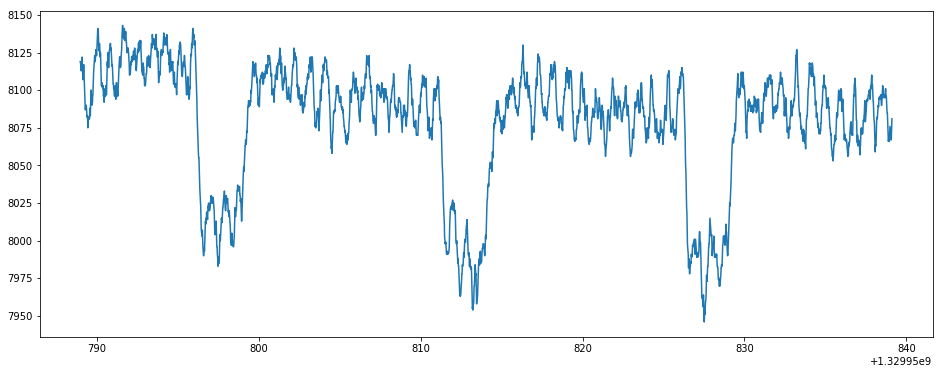

--- 1.6701860427856445 seconds ---


In [28]:
# RDP
from rdp import rdp
start = time.time()
D = []
x = da["x"]
y = da["mf3"]
for i in range(0,len(x)):
    D.append([x[i],y[i]])
dp = rdp(D,epsilon = .009)
print(len(dp))
dframe = pd.DataFrame(dp)
print(dframe.head())
x = np.array(dframe[0])
y = np.array(dframe[1])
plt.figure(figsize=(16,6))
plt.plot(x,y)
#plt.title("RDP sampling")
plt.savefig("d12/rdp.png")
plt.show()
end = time.time()
print("--- %s seconds ---" % (end - start))





--- 0.12388801574707031 seconds ---
2501


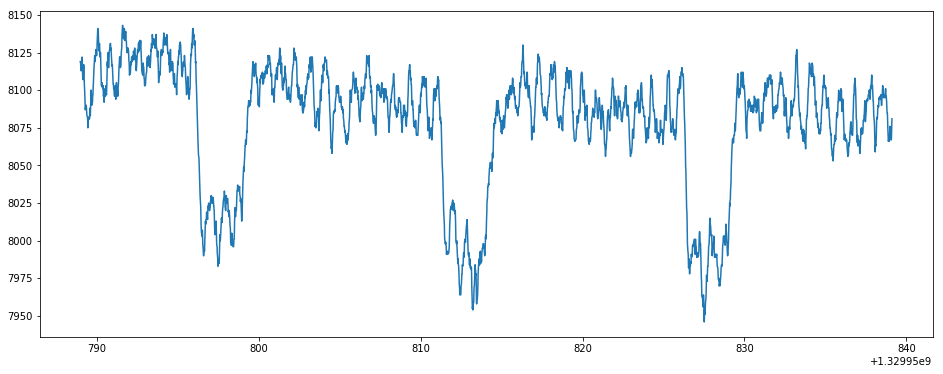

In [17]:
# VW

import visvalingamwyatt as vw
start = time.time()
D = []
X = da["x"]
Y = da["mf3"]
for i in range(0,len(X)):
    D.append([X[i],Y[i]])
simplifier = vw.Simplifier(D)
vwd = simplifier.simplify(ratio = .5)
end = time.time()
print("--- %s seconds ---" % (end - start))

print(len(vwd))
dframe = pd.DataFrame(vwd)
x = np.array(dframe[0])
y = np.array(dframe[1])
plt.figure(figsize=(16,6))
plt.plot(x,y)
#plt.title("VWD sampling")
plt.savefig("d12/vwd.png")
plt.show()

2500
                                    t    mf1    mf2   mf3             x
1   2012-02-22T16:46:28.9870216+00:00  13049  14404  8119  1.329951e+09
3   2012-02-22T16:46:29.0070267+00:00  13049  14397  8116  1.329951e+09
4   2012-02-22T16:46:29.0170276+00:00  13046  14392  8113  1.329951e+09
11  2012-02-22T16:46:29.0870301+00:00  13045  14392  8122  1.329951e+09
12  2012-02-22T16:46:29.0970227+00:00  13046  14392  8119  1.329951e+09


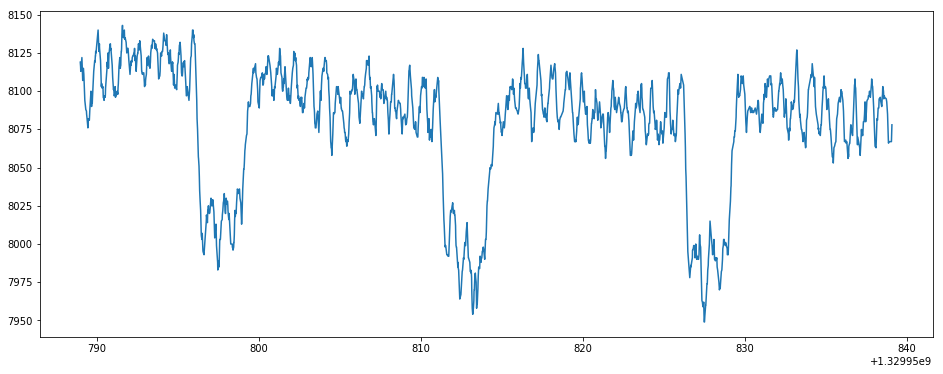

--- 0.1511378288269043 seconds ---


In [22]:
# Random 
start = time.time()
ran = da.sample(frac=0.5, replace=True)
ran = ran.sort_values(["x"])
print(len(ran))
x = np.array(ran["x"])
y = np.array(ran["mf3"])
print(ran.head())
plt.figure(figsize=(16,6))
plt.plot(x,y)
# plt.title("Random sampling")
plt.savefig("d12/random.png")

plt.show()
end = time.time()

print("--- %s seconds ---" % (end - start))



<class 'pandas.core.frame.DataFrame'>
(2500, 5)


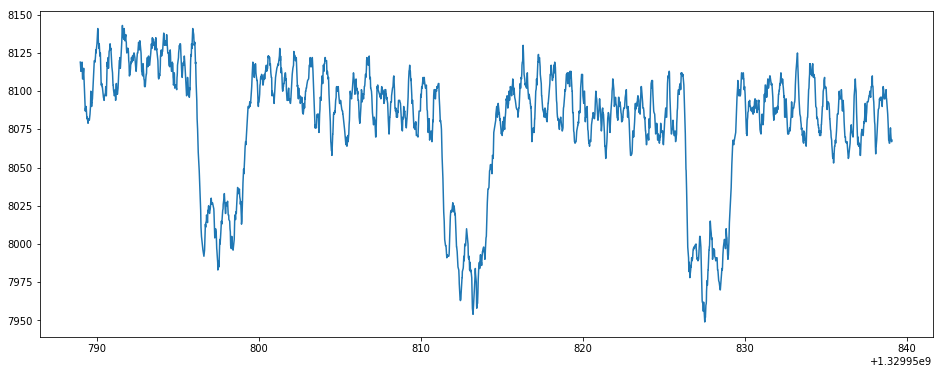

--- 0.15248990058898926 seconds ---


In [26]:
#Stratified sampling
from sklearn.model_selection import StratifiedShuffleSplit
start = time.time()


sss = StratifiedShuffleSplit(n_splits=1, test_size=0.5, random_state=0)

T = [0]*da.shape[0]
traini= sss.split(da,T)
D = pd.DataFrame()
for t,i in traini:
    print(type(da.iloc[t]))
    D = da.iloc[t]
#print(D)
print(D.shape)
D = D.sort_values(["x"])

x = np.array(D["x"])
y = np.array(D["mf3"])
plt.figure(figsize=(16,6))
plt.plot(x,y)
plt.savefig("d12/stratified.png")
plt.show()
end = time.time()

print("--- %s seconds ---" % (end - start))


